In [ ]:
import pandas as pd

import os

from gensim.models import KeyedVectors

from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from string import punctuation

import csv
import codecs
import re

import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, recall_score, precision_score, \
          accuracy_score, fbeta_score, f1_score, \
          roc_auc_score, average_precision_score, \
          log_loss, PrecisionRecallDisplay, RocCurveDisplay

from scikitplot.metrics import plot_roc

import seaborn as sns
from pretty_confusion_matrix import pp_matrix
from pretty_confusion_matrix import pp_matrix_from_data


from tqdm import tqdm

In [ ]:
NOTEBOOK_HOME = "."
DATA_DIR = NOTEBOOK_HOME + "/data/quora-question-pairs"

In [ ]:
word2vec = KeyedVectors.load_word2vec_format(NOTEBOOK_HOME + '/model-params/GoogleNews-vectors-negative300.bin', binary=True)

In [ ]:
def text_to_wordlist(text):
    text = " ".join([w for w in text.lower().split() if not w in set(stopwords.words("english"))])
    random_list = {
        r"[^A-Za-z0-9^,!.\/'+-=]": " ",
        r"what's": "what is ",
        r"\'s": " ",
        r"\'ve": " have ",
        r"can't": "cannot ",
        r"n't":" not ",
        r"i'm":"i am ",
        r"\'re": " are ",
        r"\'d": " would ",
        r"\'ll": " will ",
        r",": " ",
        r"\.": " ",
        r"!": " ! ",
        r"\/": " ",
        r"\^": " ^ ",
        r"\+": " + ",
        r"\-": " - ",
        r"\=": " = ",
        r"'": " ",
        r"(\d+)(k)": r"\g<1>000",
        r":": " : ",
        r" e g ": " eg ",
        r" b g ": " bg ",
        r" u s ": " american ",
        r"\0s": "0",
        r" 9 11 ": "911",
        r"e - mail": "email",
        r"j k": "jk",
        r"\s{2,}": " "
    }
    
    for i, v in random_list.items():
        text = re.sub(i, v, text)
    
    stemmer = SnowballStemmer('english')
    return " ".join([stemmer.stem(word) for word in text.split()])


In [ ]:
PREPROCESSED_DIR = NOTEBOOK_HOME + "/data/quora-question-pairs-preprocessed"
PREPROCESS_DATASET = False

if PREPROCESS_DATASET:
  texts_1 = []
  texts_2 = []
  labels = []
  with codecs.open(DATA_DIR+"/train.csv", encoding='utf-8') as f:
      reader = csv.reader(f, delimiter=',')
      header = next(reader)
      for values in tqdm(reader):
          texts_1.append(text_to_wordlist(values[3]))
          texts_2.append(text_to_wordlist(values[4]))
          labels.append(int(values[5]))
  print('Found %s texts in train.csv' % len(texts_1))

  if not os.path.exists(PREPROCESSED_DIR):
    os.mkdir(PREPROCESSED_DIR)

  pd.DataFrame({"texts_1": texts_1, "texts_2": texts_2, "labels": labels}).dropna().to_csv(PREPROCESSED_DIR + "/preprocessed_train.csv")
  

train_df = pd.read_csv(PREPROCESSED_DIR + "/preprocessed_train.csv").dropna()
texts_1 = train_df["texts_1"].tolist()
texts_2 = train_df["texts_2"].tolist()
labels = train_df["labels"].tolist()

In [ ]:
TEST = False
if TEST:
  if PREPROCESS_DATASET:
    test_texts_1 = []
    test_texts_2 = []
    test_ids = []
    with codecs.open(DATA_DIR+"/test.csv", encoding='utf-8') as f:
        reader = csv.reader(f, delimiter=',')
        header = next(reader)
        for values in tqdm(reader):
            test_texts_1.append(text_to_wordlist(values[1]))
            test_texts_2.append(text_to_wordlist(values[2]))
            test_ids.append(values[0])
    print('Found %s texts in test.csv' % len(test_texts_1))
    
    if not os.path.exists(PREPROCESSED_DIR):
      os.mkdir(PREPROCESSED_DIR)
  
    pd.DataFrame({"texts_1": test_texts_1, "texts_2": test_texts_1, "test_ids": test_ids}).dropna().to_csv(PREPROCESSED_DIR + "/preprocessed_test.csv")
  
  test_df = pd.read_csv(PREPROCESSED_DIR + "/preprocessed_test.csv").dropna()
  test_texts_1 = test_df["texts_1"].tolist()
  test_texts_2 = test_df["texts_2"].tolist()
  test_ids = test_df["test_ids"].tolist()


In [ ]:
train_texts_1, test_texts_1, train_texts_2, test_texts_2, train_labels, test_labels = train_test_split(texts_1, texts_2, labels, test_size=0.25)

In [ ]:
def ngram_cosine_similarity(doc1, doc2):
  if not doc1 or doc1 is np.nan: return 0
  if not doc2: return 0
  doc1_vecs = []
  for word in doc1.split():
    if word in word2vec.vocab:
      doc1_vecs.append(word2vec.get_vector(word))
  doc2_vecs = []
  for word in doc2.split():
    if word in word2vec.vocab:
      doc2_vecs.append(word2vec.get_vector(word))
  if not doc1_vecs:
    return 0
  if not doc2_vecs:
    return 0
  
  doc1_centroid = np.mean(doc1_vecs, axis=0)
  doc2_centroid = np.mean(doc2_vecs, axis=0)

  return np.dot(doc1_centroid, doc2_centroid) / (np.sqrt(np.dot(doc1_centroid, doc1_centroid)) * np.sqrt(np.dot(doc2_centroid, doc2_centroid)))

def get_all_cosine_similarities(doc1, doc2):
  res = []
  for text1, text2 in zip(doc1, doc2):
    try:
      res.append(ngram_cosine_similarity(text1, text2))
    except Exception as e:
      print(e)
      print(text1, text2)
      break
      print("hllo")
  return res

In [ ]:
preds = pd.DataFrame({"texts_1": texts_1[:5], "texts_2": texts_2[:5], "similarity": get_all_cosine_similarities(texts_1[:5], texts_2[:5])})
preds

,texts_1,texts_2,similarity
0,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,0.954794
1,what is the story of kohinoor koh - i - noor d...,what would happen if the indian government sto...,0.808256
2,how can i increase the speed of my internet co...,how can internet speed be increased by hacking...,0.798543
3,why am i mentally very lonely how can i solve it,find the remainder when math 23 ^ 24 math is d...,0.508553
4,which one dissolve in water quikly sugar salt ...,which fish would survive in salt water,0.661036


In [ ]:
preds = np.array(get_all_cosine_similarities(test_texts_1, test_texts_2), dtype=float)

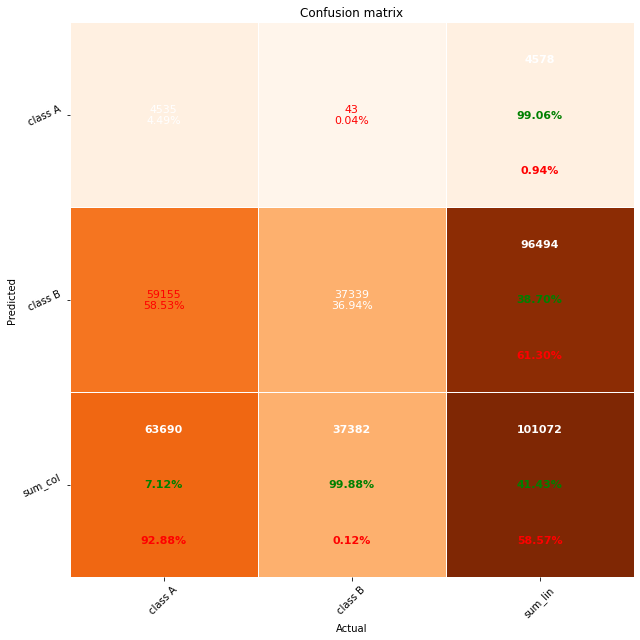

In [ ]:
pp_matrix_from_data(test_labels, preds > 0.5)

In [ ]:
y_pred_class = preds > 0.5
tn, fp, fn, tp = confusion_matrix(test_labels, y_pred_class).ravel()
false_positive_rate = fp / (fp + tn)
false_negative_rate = fn / (tp + fn)
true_negative_rate = tn / (tn + fp)
recall = recall_score(test_labels, y_pred_class) # or optionally tp / (tp + fn)
precision = precision_score(test_labels, y_pred_class)
accuracy = accuracy_score(test_labels, y_pred_class)
f1= f1_score(test_labels, y_pred_class)
f2 = fbeta_score(test_labels, y_pred_class, beta = 2)
roc_auc = roc_auc_score(test_labels, preds)
avg_precision = average_precision_score(test_labels, preds)
loss = log_loss(test_labels, preds)


print("false positive rate", false_positive_rate)
print("false negetive rate", false_negative_rate)
print("false negetive rate", false_negative_rate)
print("true negetive rate", true_negative_rate)
print("recall", recall)
print("precision", precision)
print("accuracy", accuracy)
print("f1", f1)
print("f2", f2)
print("roc_auc", roc_auc)
print("avg_precision", avg_precision)
print("loss", loss)


false positive rate 0.928795729313864
false negetive rate 0.0011502862340163715
false negetive rate 0.0011502862340163715
true negetive rate 0.07120427068613597
recall 0.9988497137659836
precision 0.386956701971107
accuracy 0.4142987177457654
f1 0.5578146941946279
f2 0.7588548991553601
roc_auc 0.7264945350115946
avg_precision 0.5351971085119713
loss 1.346762930784037


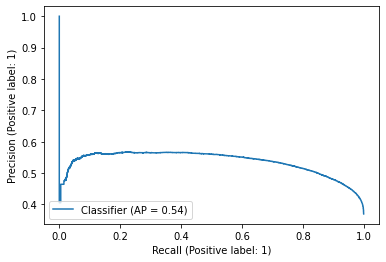

In [ ]:
PrecisionRecallDisplay.from_predictions(test_labels, preds)


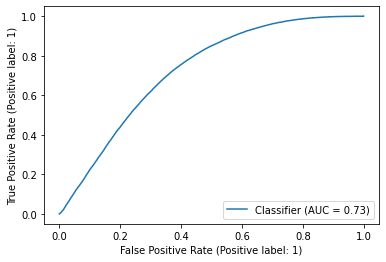

In [ ]:
RocCurveDisplay.from_predictions(test_labels, preds)


# Deep Learning Model

In [ ]:
MAX_NB_WORDS = 200000
MAX_SEQUENCE_LENGTH = 30
EMBEDDING_DIM = 300

# WEIGHT_IMP = (1, 0)
WEIGHT_IMP = (0.5, 1.3)

tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=MAX_NB_WORDS)

tokenizer.fit_on_texts(train_texts_1 + train_texts_2 + test_texts_1 + test_texts_2)

sequences_1 = tokenizer.texts_to_sequences(train_texts_1)
sequences_2 = tokenizer.texts_to_sequences(train_texts_2)
test_sequences_1 = tokenizer.texts_to_sequences(test_texts_1)
test_sequences_2 = tokenizer.texts_to_sequences(test_texts_2)

train_data_1 = tf.keras.preprocessing.sequence.pad_sequences(sequences_1, maxlen=MAX_SEQUENCE_LENGTH)
train_data_2 = tf.keras.preprocessing.sequence.pad_sequences(sequences_2, maxlen=MAX_SEQUENCE_LENGTH)
train_labels = np.array(train_labels)
test_data_1 = tf.keras.preprocessing.sequence.pad_sequences(test_sequences_1, maxlen=MAX_SEQUENCE_LENGTH)
test_data_2 = tf.keras.preprocessing.sequence.pad_sequences(test_sequences_2, maxlen=MAX_SEQUENCE_LENGTH)
test_labels = np.array(test_labels)

nb_words = min(MAX_NB_WORDS, len(tokenizer.word_index))+1

embedding_matrix = np.zeros((nb_words, EMBEDDING_DIM))
for word, i in tqdm(tokenizer.word_index.items()):
    if word in word2vec.vocab:
        embedding_matrix[i] = word2vec.get_vector(word)

train_data_1, train_data_2 = np.vstack((train_data_1,train_data_2)), np.vstack((train_data_2, train_data_1))
train_labels = np.concatenate((train_labels, train_labels))

train_data_1, cv_data_1, train_data_2, cv_data_2, train_labels, cv_labels = train_test_split(train_data_1, train_data_2, train_labels)
weight_val = np.ones(len(cv_labels))

100%|██████████| 85518/85518 [00:00<00:00, 381713.04it/s]


In [ ]:
def get_model():
  embedding_layer = Embedding(
    nb_words,
    EMBEDDING_DIM,
    weights=[embedding_matrix],
    input_length=MAX_SEQUENCE_LENGTH,
    trainable=False
  )
  lstm_layer = LSTM(175, dropout=0.2, recurrent_dropout=0.2)

  sequence_1_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
  embedded_sequences_1 = embedding_layer(sequence_1_input)
  x1 = lstm_layer(embedded_sequences_1)

  sequence_2_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
  embedded_sequences_2 = embedding_layer(sequence_2_input)
  x2 = lstm_layer(embedded_sequences_2)

  merged = tf.keras.layers.concatenate([x1, x2])
  merged = Dropout(0.2)(merged)
  merged = BatchNormalization()(merged)

  merged = Dense(120, activation='relu')(merged)
  merged = Dropout(0.2)(merged)
  merged = BatchNormalization()(merged)

  preds = Dense(1, activation='sigmoid')(merged)

  model = tf.keras.models.Model(
    inputs=[sequence_1_input, sequence_2_input],
    outputs=preds
  )
  model.compile(
    loss='binary_crossentropy',
    optimizer='nadam',
    metrics=['acc']
  )

  return model

In [ ]:
LOAD_MODEL = True

if LOAD_MODEL:
  model = tf.keras.models.load_model(NOTEBOOK_HOME + "/model")

else:
  model = get_model()
  model.summary()

  early_stopping = EarlyStopping(monitor='val_loss', patience=5)

  hist = model.fit(
      [train_data_1, train_data_2], 
      train_labels,
      validation_data=(
          [cv_data_1, cv_data_2], cv_labels, weight_val
      ),
      epochs=200,
      batch_size=2048,
      shuffle=True,
      callbacks=[early_stopping]
  )

  model.save(NOTEBOOK_HOME + "/model")

Predicting with both (x1,x2) and (x2, x1) and averaging them to get final prediction

In [ ]:
preds = model.predict([test_data_1, test_data_2], batch_size=8192, verbose=1)
preds += model.predict([test_data_2, test_data_1], batch_size=8192, verbose=1)
preds /= 2

13/13 [==============================] - 2s 174ms/step


In [ ]:
preds[:10]

array([[9.9818230e-01],
       [7.9233825e-02],
       [5.1435945e-05],
       [1.3830492e-01],
       [2.5490251e-01],
       [1.1034496e-03],
       [1.8742429e-01],
       [1.0114317e-02],
       [8.4429574e-01],
       [6.1898017e-01]], dtype=float32)

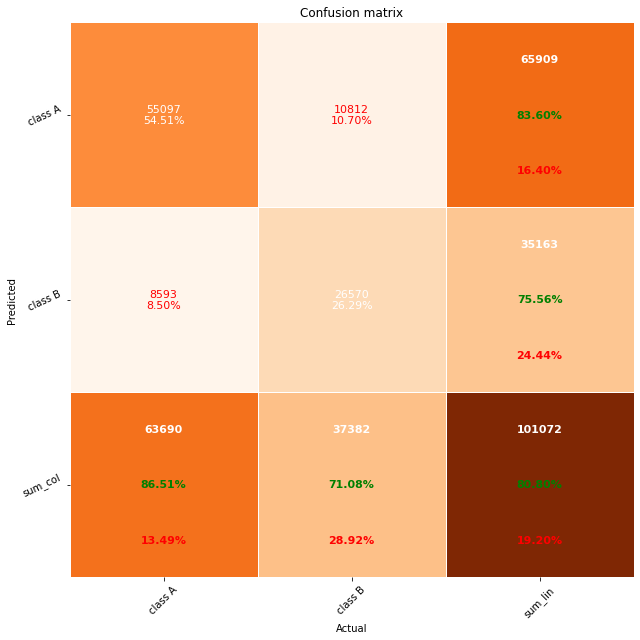

In [ ]:
pp_matrix_from_data(test_labels, preds > 0.5)

In [ ]:
y_pred_class = preds > 0.5
tn, fp, fn, tp = confusion_matrix(test_labels, y_pred_class).ravel()
false_positive_rate = fp / (fp + tn)
false_negative_rate = fn / (tp + fn)
true_negative_rate = tn / (tn + fp)
recall = recall_score(test_labels, y_pred_class) # or optionally tp / (tp + fn)
precision = precision_score(test_labels, y_pred_class)
accuracy = accuracy_score(test_labels, y_pred_class)
f1= f1_score(test_labels, y_pred_class)
f2 = fbeta_score(test_labels, y_pred_class, beta = 2)
roc_auc = roc_auc_score(test_labels, preds)
avg_precision = average_precision_score(test_labels, preds)
# loss = log_loss(test_labels, preds)


print("false positive rate", false_positive_rate)
print("false negetive rate", false_negative_rate)
print("false negetive rate", false_negative_rate)
print("true negetive rate", true_negative_rate)
print("recall", recall)
print("precision", precision)
print("accuracy", accuracy)
print("f1", f1)
print("f2", f2)
print("roc_auc", roc_auc)
print("avg_precision", avg_precision)
# print("loss", loss)


false positive rate 0.13491913958235202
false negetive rate 0.2892301107484886
false negetive rate 0.2892301107484886
true negetive rate 0.865080860417648
recall 0.7107698892515114
precision 0.7556238091175383
accuracy 0.8080081526040842
f1 0.7325108553311738
f2 0.7193095494636987
roc_auc 0.8789198063499403
avg_precision 0.81550464518762


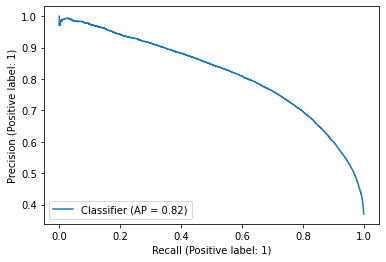

In [ ]:
PrecisionRecallDisplay.from_predictions(test_labels, preds)


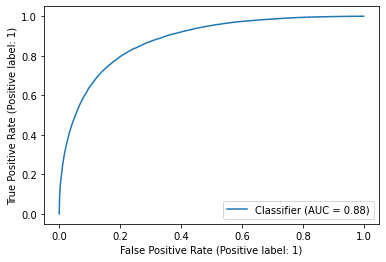

In [ ]:
RocCurveDisplay.from_predictions(test_labels, preds)


In [ ]:
preds

array([[9.9818230e-01],
       [7.9233825e-02],
       [5.1435945e-05],
       ...,
       [9.3744922e-01],
       [9.2733371e-01],
       [2.9404040e-02]], dtype=float32)

In [ ]:
preds_df = pd.DataFrame({"text1": test_texts_1, "text2": test_texts_2, "label": test_labels, "pred": preds.squeeze()})

wrong_idx = np.where(preds.round().squeeze().astype(int) != test_labels)[0]

preds_wrong_df = preds_df.iloc[wrong_idx]

preds_wrong_df.to_csv(NOTEBOOK_HOME + "/wrong_lstm_preds.csv")
preds_wrong_df

,text1,text2,label,pred
4,why should i jailbreak my iphone,why should i jailbreak my iphone 4,1,0.254903
11,is india really a nuclear triad,in spite of having all the infrastructure and ...,0,0.612677
14,which is better between xbox or ps4,specifications - wise which is the better cons...,1,0.124185
20,how do you study statistical sciences,how do you study the statistical sciences,1,0.403408
23,is it wrong to fall in love with your best fri...,is it okay to fall in love with your best girl...,0,0.708565
...,...,...,...,...
101059,how did fivethirtyeight com get its prediction...,how did the 2016 us election polls get it so w...,1,0.469695
101062,how do i learn apache spark,what is the best way to learn apache spark fro...,0,0.830989
101063,is ezetimibe good or bad,is masturbation good or bad,0,0.735686
101066,what is the difference between earthing and gr...,what is difference between earthing and ground...,1,0.349317
